In [1]:
import torch


In [3]:
print(torch.__version__)

2.4.0


In [5]:
import os
import torchvision
import torchvision.transforms as transforms

In [7]:
print(torchvision.__version__)

0.19.0


In [9]:
os.listdir('C:/Users/khush/OneDrive/Documents/dataset1/TRAIN')


['organic', 'recyclable']

In [11]:
training_dataset_path = 'C:/Users/khush/OneDrive/Documents/dataset1/TRAIN'

In [13]:
training_transforms =transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [15]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path,transform=training_transforms)

In [17]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32 , shuffle=False)

In [19]:
def get_mean_and_std(loader):
    mean=0.
    std=0.
    total_images_count=0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=image_count_in_a_batch
    mean /= total_images_count
    std /= total_images_count

    return mean,std


In [ ]:

get_mean_and_std(train_loader)

In [116]:
import matplotlib.pyplot as plt
import numpy as np


In [118]:
train_dataset_path = 'C:/Users/khush/OneDrive/Documents/dataset1/TRAIN'
test_dataset_path= 'C:/Users/khush/OneDrive/Documents/dataset1/TEST'


In [120]:
mean = [0.6879, 0.6366, 0.5604]
std = [0.2079, 0.2177, 0.2383]

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])


In [122]:
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform = test_transforms)

In [124]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset,batch_size = 6, shuffle=True)
    batch=next(iter(loader))
    images,labels=batch

    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 0, 1, 1, 1, 0])


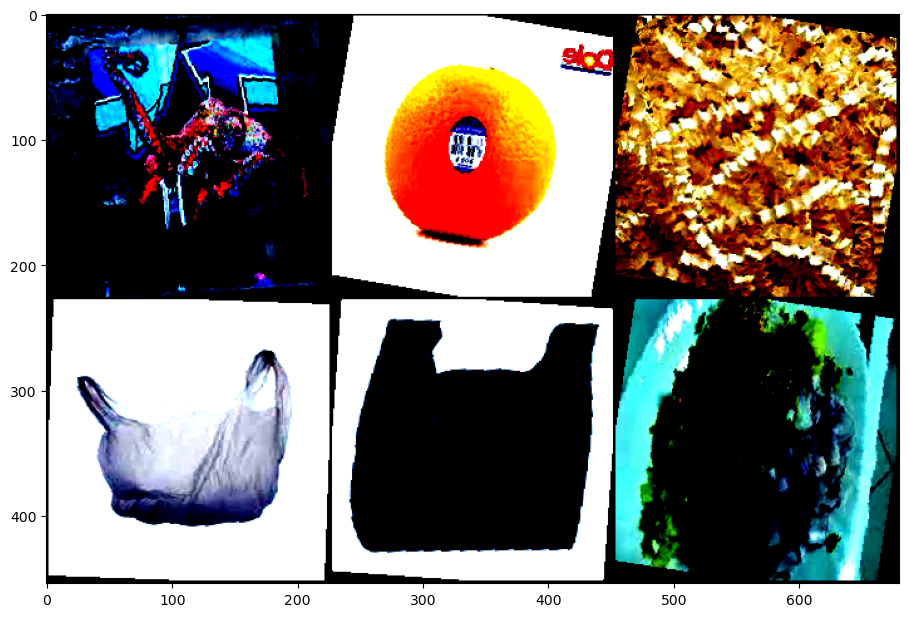

In [126]:
show_transformed_images(train_dataset)

In [128]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [142]:
def set_device():
    if torch.cuda.is_available():
        dev="cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [144]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0
    for epoch in range(n_epochs):
        print("Epoch number %d" % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        # This loop should be inside the epoch loop
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()
        
            optimizer.step()
        
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * running_correct / total

        print("         - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" % (running_correct, total, epoch_acc, epoch_loss))
     
        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)

        if(test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)
    
    print("Finished")
    return model
    

In [146]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100.0 * predicted_correctly_on_epoch / total

    print("         - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" % (predicted_correctly_on_epoch, total, epoch_acc))
     
    return epoch_acc

In [148]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch' : epoch + 1,
        'model' : model.state_dict(),
        'best accuracy' : best_acc,
        'optimizer' : optimizer.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [150]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=True)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 2
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.003)


In [152]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 150)


Epoch number 1


KeyboardInterrupt: 

In [154]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

C:\Users\khush\AppData\Local\Temp\ipykernel_15192\50787370.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best_checkpoint.pth.tar')


FileNotFoundError: [Errno 2] No such file or directory: 'model_best_checkpoint.pth.tar'

In [ ]:
print(checkpoint['epoch'])
print(checkpoint['comments'])
print(checkpoint['best accuracy'])

In [ ]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 2
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'best_model.pth')